# check on signal quality per concert

derived from http://localhost:8888/notebooks/Stavanger/Signal_Preparation/CardioProcessing.ipynb

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act
import respy_test as respy

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al

In [3]:
%reload_ext autoreload

In [5]:
# audio file locations in
datadir = '../Data2024/'
# audio_loc = '../Data2024/Audio/Full_Zero/'
audio_loc = '../Data2024/Audio/Piece_wise/'
# audio file locations out
Event_timings  = pd.read_csv(datadir + 'Timing/Lydo2024_DayEvents.csv',index_col = 0)
Event_timings['dTime_start'] = pd.to_datetime(Event_timings['DateTime_start'])
Event_timings['dTime_end'] = pd.to_datetime(Event_timings['DateTime_end'])
PartDets = pd.read_csv('../Data2024/Participants/Participant_Metadata.csv',index_col=0)

Piece_timings  = pd.read_csv(datadir + 'Timing/Lydo2024_Performance_events_red.csv')
Piece_timings

Event Related Event_Type                Full_Title  \
0         Tuning    Tune      Music                       NaN   
1          Pause    Tune    Silence                       NaN   
2          Marsj    Trad      Music         Gammel Jegermarsj   
3             MC    Trad     Speech                       NaN   
4          Ringe    Intr      Music                       NaN   
..           ...     ...        ...                       ...   
62            MC    Ross     Speech                       NaN   
63  Wilhelm Tell    Ross      Music  Guillaume Tell Ouverture   
64      Applause    Ross   Applause                       NaN   
65            MC    Conc     Speech                       NaN   
66           End    Conc        NaN                       NaN   

                         Composer  Performer Screen           RD           C1  \
0                             NaN        NaN    NaN     0.000000     0.000000   
1                             NaN        NaN    NaN    49.000000    38.000000   
2   arr. Frederik Schöildberg (?)        NaN    NaN   589.203333    45.320000   
3                             NaN        NaN    NaN   606.933333    63.086667   
4                             NaN        NaN    NaN   612.912000    77.263333   
..                            ...        ...    ...          ...          ...   
62                            NaN        NaN    NaN  3334.570667  2738.355000   
63              Gioachino Rossino        NaN    NaN  3340.416000  2744.637000   
64                            NaN        NaN    NaN  3738.709333  3149.079000   
65                            NaN        NaN    NaN  3746.026667  3164.244000   
66                            NaN        NaN    NaN  3747.840000  3172.950000   

          C2           C3           C4           C5           C6           C7  
0      0.000     0.000000     0.000000     0.000000     0.000000     0.000000  
1     36.810    41.300000    38.400000    45.200000    36.500000    37.900000  
2     41.868    46.013333    42.478500    48.032000    41.860000    43.392000  
3     59.780    64.253333    60.690000    65.960000    59.901333    61.077333  
4     88.020    76.248667    74.331000    79.840000    73.653333    75.242667  
..       ...          ...          ...          ...          ...          ...  
62  2740.158  2704.221000  2675.220000  2632.998667  2644.581333  2765.760000  
63  2746.438  2711.202000  2680.788000  2639.896000  2650.144000  2770.816000  
64  3142.804  3122.261333  3084.543000  3036.590667  3043.656000  3164.588000  
65  3161.904  3139.650000  3102.421333  3056.760000  3064.002667          NaN  
66  3167.904  3151.173000  3112.277333  3080.400000  3071.376000  3235.848000  

[67 rows x 15 columns]

In [26]:
data_dir='/Volumes/TaeTae/Stavangar/bic2024'
sep = '/'
DATAtag='EQDATA'
# df_datafiles = eq.eq_recordings(data_dir,DATAtag,sep)
# df_datafiles.iloc[:5,:]

concert_loc = {
    'RD':data_dir + '/RD/',
    'C1':data_dir + '/C1/',
    'C2':data_dir + '/C2/',
    'C3':data_dir + '/C3/',
    'C4':data_dir + '/C4/',
    'C5':data_dir + '/C5/',
    'C6':data_dir + '/C6/',
    'C7':data_dir + '/C7/'}

# concerts = list(concert_loc.keys())
concerts =['RD', 'C1','C2','C3', 'C4', 'C5', 'C6', 'C7']

In [28]:
datafile_type = 'CIBI' # EQCIBI and MSCIBI
piece = 'Full'
data_loc = concert_loc[concert]

# first find data for each participant for that concert
sig_folders = {}
for c in concerts:
    data_loc = concert_loc[c]
    files = os.listdir(data_loc)
    files.sort()
    sig_files = {}
    for f in files: 
        if f.endswith(datafile_type+'.csv'): 
            if not f.startswith('._'):
                partID = f.split('_')[2]
                sig_files[partID] = data_loc+f
    sig_folders[c] = sig_files.copy()

In [8]:
Piece_timings

Event Related Event_Type                Full_Title  \
0         Tuning    Tune      Music                       NaN   
1          Pause    Tune    Silence                       NaN   
2          Marsj    Trad      Music         Gammel Jegermarsj   
3             MC    Trad     Speech                       NaN   
4          Ringe    Intr      Music                       NaN   
..           ...     ...        ...                       ...   
62            MC    Ross     Speech                       NaN   
63  Wilhelm Tell    Ross      Music  Guillaume Tell Ouverture   
64      Applause    Ross   Applause                       NaN   
65            MC    Conc     Speech                       NaN   
66           End    Conc        NaN                       NaN   

                         Composer  Performer Screen           RD           C1  \
0                             NaN        NaN    NaN     0.000000     0.000000   
1                             NaN        NaN    NaN    49.000000    38.000000   
2   arr. Frederik Schöildberg (?)        NaN    NaN   589.203333    45.320000   
3                             NaN        NaN    NaN   606.933333    63.086667   
4                             NaN        NaN    NaN   612.912000    77.263333   
..                            ...        ...    ...          ...          ...   
62                            NaN        NaN    NaN  3334.570667  2738.355000   
63              Gioachino Rossino        NaN    NaN  3340.416000  2744.637000   
64                            NaN        NaN    NaN  3738.709333  3149.079000   
65                            NaN        NaN    NaN  3746.026667  3164.244000   
66                            NaN        NaN    NaN  3747.840000  3172.950000   

          C2           C3           C4           C5           C6           C7  
0      0.000     0.000000     0.000000     0.000000     0.000000     0.000000  
1     36.810    41.300000    38.400000    45.200000    36.500000    37.900000  
2     41.868    46.013333    42.478500    48.032000    41.860000    43.392000  
3     59.780    64.253333    60.690000    65.960000    59.901333    61.077333  
4     88.020    76.248667    74.331000    79.840000    73.653333    75.242667  
..       ...          ...          ...          ...          ...          ...  
62  2740.158  2704.221000  2675.220000  2632.998667  2644.581333  2765.760000  
63  2746.438  2711.202000  2680.788000  2639.896000  2650.144000  2770.816000  
64  3142.804  3122.261333  3084.543000  3036.590667  3043.656000  3164.588000  
65  3161.904  3139.650000  3102.421333  3056.760000  3064.002667          NaN  
66  3167.904  3151.173000  3112.277333  3080.400000  3071.376000  3235.848000  

[67 rows x 15 columns]

In [9]:
sig_files = sig_folders[concert].copy()    
sigName = 'CIBI'
C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

piece = 'Full'
sf = 10
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
C_times

Event Event_Type Related           C3
0         Tuning      Music    Tune     0.000000
1          Pause    Silence    Tune    41.300000
2          Marsj      Music    Trad    46.013333
3             MC     Speech    Trad    64.253333
4          Ringe      Music    Intr    76.248667
..           ...        ...     ...          ...
58            MC     Speech    Ross  2704.221000
59  Wilhelm Tell      Music    Ross  2711.202000
60      Applause   Applause    Ross  3122.261333
61            MC     Speech    Conc  3139.650000
62           End        NaN    Conc  3151.173000

[63 rows x 4 columns]

In [10]:
PartIDs = list(sig_files.keys())
len(PartIDs)#-len(player_order)

30

## check individual cardio details

In [11]:
partN = 1
p =  PartIDs[partN]
print(p)

df_sig = pd.DataFrame(index = time_s)

BR604


In [12]:
V = pd.read_csv(sig_files[p])
sig_t = V['c_sTime']
sig_v = V['Interbeat Interval (MS)']
HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
df_sig.loc[:,partID] = f(time_s)

In [13]:
event_palette = {'Applause':(0.388,0.286,0.275),'Speech':(0.263,0.467,0.718),'Music':(0.878,0.482,0.180)}
event_hatching = {'Applause':'xx', 'Speech':'', 'Music':'...'}
bpm_range = [40,180]

In [14]:
concert = 'C4'

In [15]:

sig_files = sig_folders[concert].copy()   

C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

piece = 'Full'
sf = 10
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

C_times['Xticklabels'] = ''
C_times.loc[C_times['Event_Type']=='Music','Xticklabels'] = C_times.loc[C_times['Event_Type']=='Music','Related']
# C_times

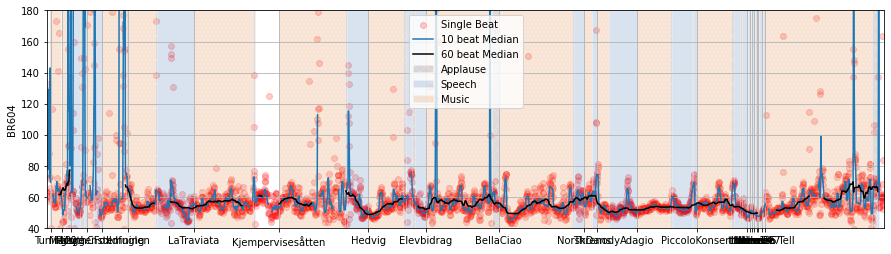

In [16]:
event_times = C_times[concert]
event_types = C_times['Event_Type']
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

V = pd.read_csv(sig_files[p])
sig_t = V['c_sTime']
sig_v = V['Interbeat Interval (MS)']
df_sig = pd.DataFrame(index = time_s)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,4])
ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
df_sig.loc[:,'10 beat Median'] = f(time_s)
df_sig.plot(ax = ax1)

HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
df_sig.loc[:,'60bMed'] = f(time_s)
df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 beat Median')

time_start =  event_times[0]-5
event_types = event_types
ax1.margins(0)
for ev in event_palette.keys():
    ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
ax1.legend()

for i in range(len(event_times)-1):
    et = event_types[i]
    if et in event_palette.keys():
        ei= event_times.iloc[i]
        ej = event_times.iloc[i+1]
        ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
ax1.set_ylim(bpm_range)
ax1.set_ylabel(p)

M_times = C_times.loc[C_times['Event_Type']=='Music',:]

ax1.set_xticks(M_times[concert])
ax1.set_xticklabels(M_times['Event'])
ax1.grid()

plt.show()

BR604


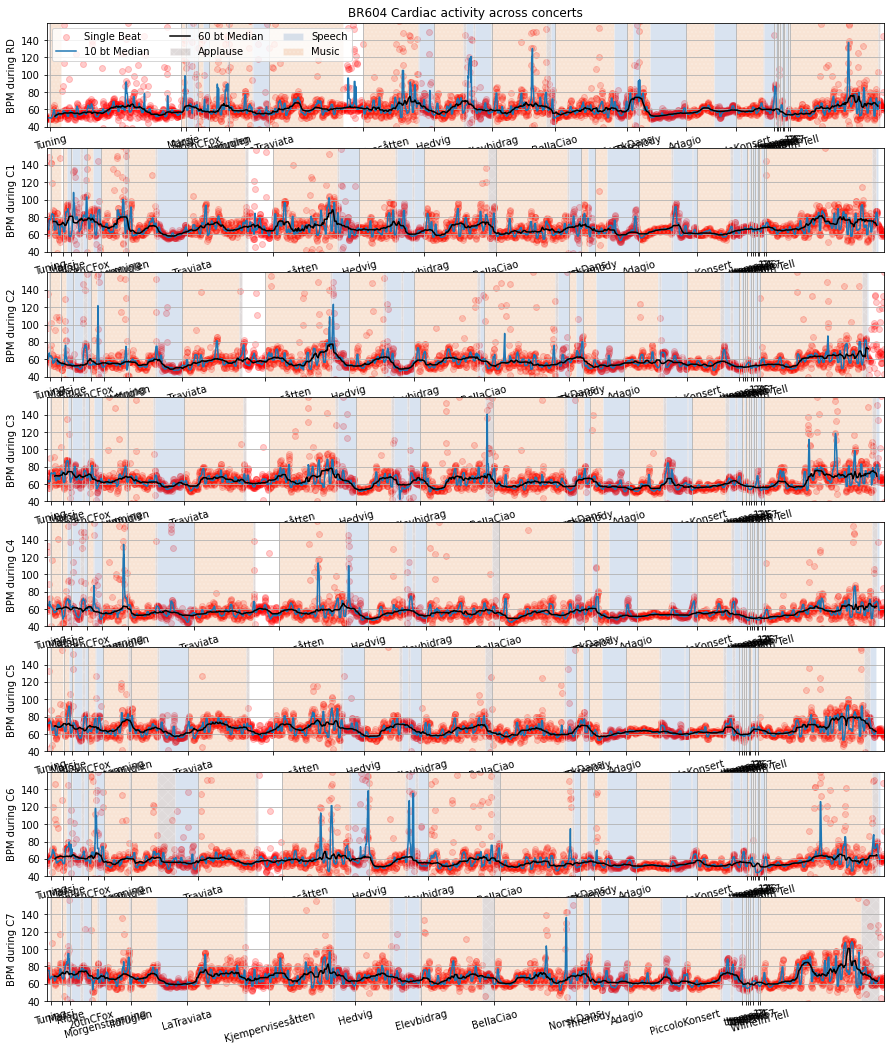

In [23]:
datafile_type = 'CIBI'
bpm_range = [40,160]
partID =  PartIDs[partN]
print(partID)

fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,18])

for j in range(len(concerts)):
    concert = concerts[j]

    C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
    C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
    M_times = C_times.loc[C_times['Event_Type']=='Music',:]
    event_times = C_times[concert]
    event_types = C_times['Event_Type']
    
    s_time = -15 #C_times.loc[0,concert]
    e_time = C_times[concert].iloc[-1]
    dur = e_time - s_time
    time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
    
    data_loc = concert_loc[concert] + piece + '/'
    sig_files = sig_folders[concert].copy() 
    if partID in sig_files.keys():
        V = pd.read_csv(sig_files[partID])

        # cut extreme outliers
        V = V.loc[V['Interbeat Interval (MS)']>330,:]
        sig_t = V['c_sTime']
        sig_v = V['Interbeat Interval (MS)']

        df_sig = pd.DataFrame(index = time_s)
        ax1 = ax[j]
        ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

        HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'10 bt Median'] = f(time_s)
        df_sig['10 bt Median'].plot(ax = ax1,label = '10 bt Median')

        HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'60bMed'] = f(time_s)
        df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')
        

        
        time_start =  event_times[0]-5
        event_types = event_types
        ax1.margins(0)
        for ev in event_palette.keys():
            ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
        if j == 0:
            #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
            ax1.legend(ncol=3)

        for i in range(len(event_times)-1):
            et = event_types[i]
            if et in event_palette.keys():
                ei= event_times.iloc[i]
                ej = event_times.iloc[i+1]
                ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
        
        ax1.set_ylim(bpm_range)
        ax1.set_yticks([40,60,80,100,120,140])
        ax1.set_xticks(M_times[concert])
        ax1.set_xticklabels(M_times['Event'],rotation = 15)
        ax1.grid()
        ax1.set_ylabel('BPM during ' + concert)
        
ax[0].set_title(' '.join([partID,'Cardiac activity across concerts']))

plt.savefig('_'.join(['./plots/Cardiac',partID,piece,'BPM.jpg']),bbox_inches = 'tight',dpi = 200)

plt.show()

In [25]:
sig_files[partID]

'/Volumes/TaeTae/Stavangar/bic2024//C3/._C3_FULL_BR606_EQCIBI.csv'

In [30]:
datafile_type = 'EQCIBI'
piece = 'Full'
sigName = 'CIBI'
bpm_range = [40,160]
for partID in PartIDs:
    print(partID)

    fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,18])

    for j in range(len(concerts)):
        concert = concerts[j]

        C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
        C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
        M_times = C_times.loc[C_times['Event_Type']=='Music',:]
        event_times = C_times[concert]
        event_types = C_times['Event_Type']

        s_time = -15 #C_times.loc[0,concert]
        e_time = C_times[concert].iloc[-1]
        dur = e_time - s_time
        time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

        data_loc = concert_loc[concert] + piece + '/'
        sig_files = sig_folders[concert].copy() 
        if partID in sig_files.keys():
            V = pd.read_csv(sig_files[partID])

            # cut extreme outliers
            V = V.loc[V['Interbeat Interval (MS)']>330,:]
            sig_t = V['c_sTime']
            sig_v = V['Interbeat Interval (MS)']

            df_sig = pd.DataFrame(index = time_s)
            ax1 = ax[j]
            ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

            HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'10 bt Median'] = f(time_s)
            df_sig['10 bt Median'].plot(ax = ax1,label = '10 bt Median')

            HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'60bMed'] = f(time_s)
            df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')


            time_start =  event_times[0]-5
            event_types = event_types
            ax1.margins(0)
            for ev in event_palette.keys():
                ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
            if j == 0:
                #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
                ax1.legend(ncol=3)

            for i in range(len(event_times)-1):
                et = event_types[i]
                if et in event_palette.keys():
                    ei= event_times.iloc[i]
                    ej = event_times.iloc[i+1]
                    ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)

            ax1.set_ylim(bpm_range)
            ax1.set_yticks([50,60,70,80,90,100,110,120,130,140,150])
            ax1.set_xticks(M_times[concert])
            ax1.set_xticklabels(M_times['Event'],rotation = 7)
            ax1.grid()
            ax1.set_ylabel('BPM during ' + concert)

    ax[0].set_title(' '.join([partID,'Cardiac activity across concerts']))
    plt.savefig('_'.join(['./plots/BPM/Cardiac',partID,piece,'BPM.jpg']),bbox_inches = 'tight',dpi = 200)
    plt.close()


FULL
BR604
BR605
BR606
BR608
BR609
LS404
LS405
LS407
LS409
LS410
PC702
PC709
PC710
VA304
VA305
VA309
VN101
VN104
VN105
VN109
VN110
VN111
VN201
VN206
VN211
VN212
WW504
WW506
WW508


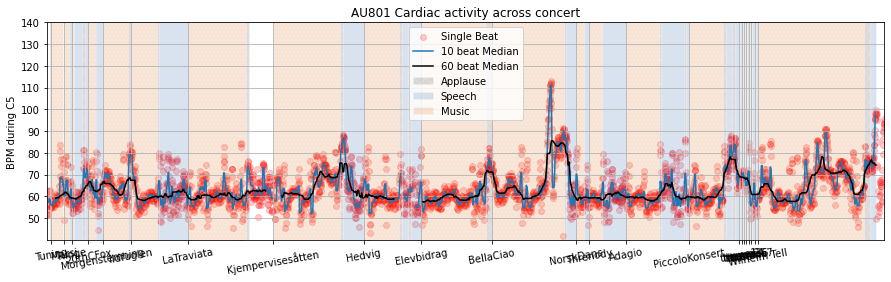

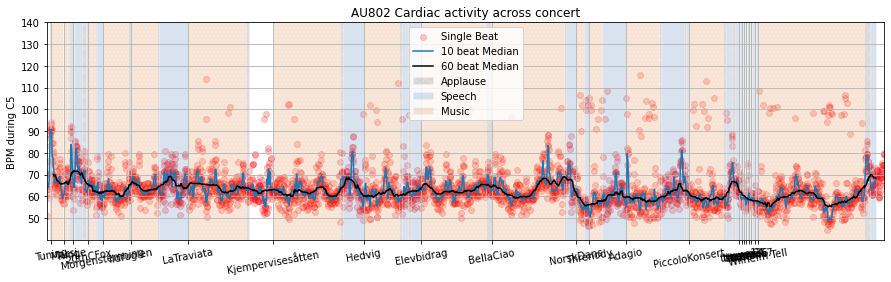

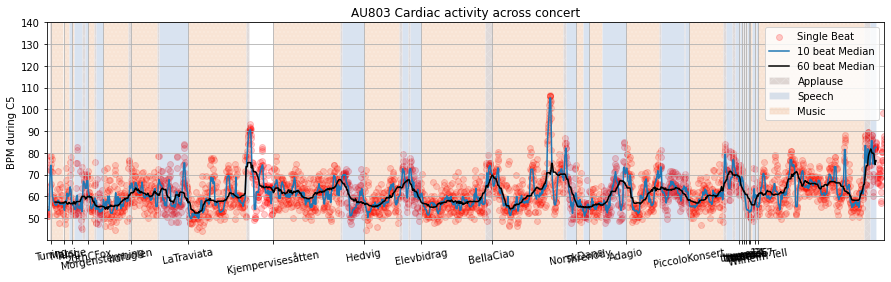

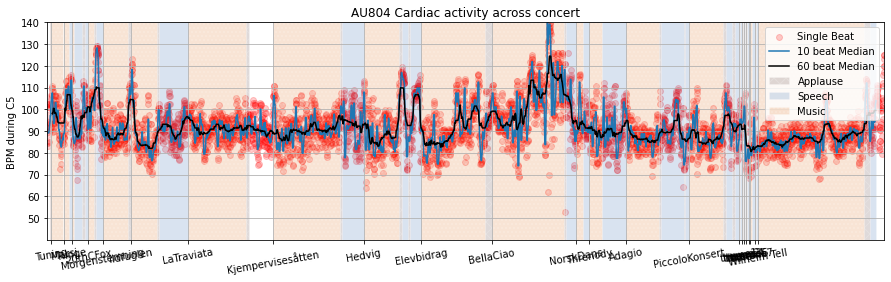

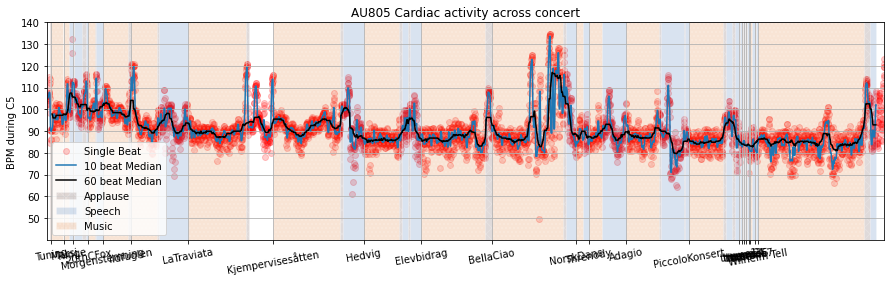

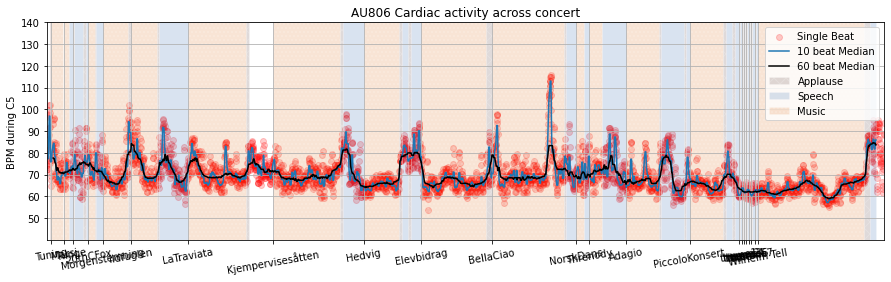

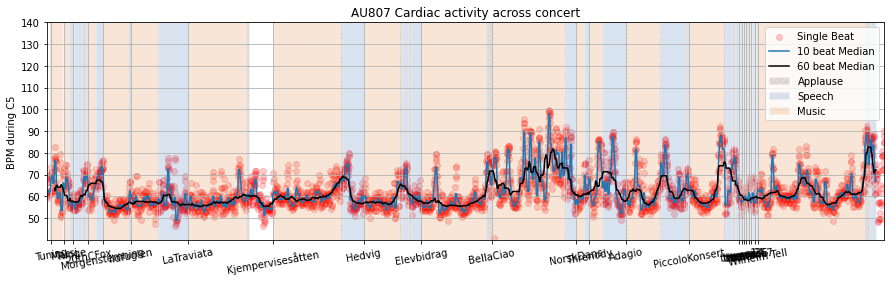

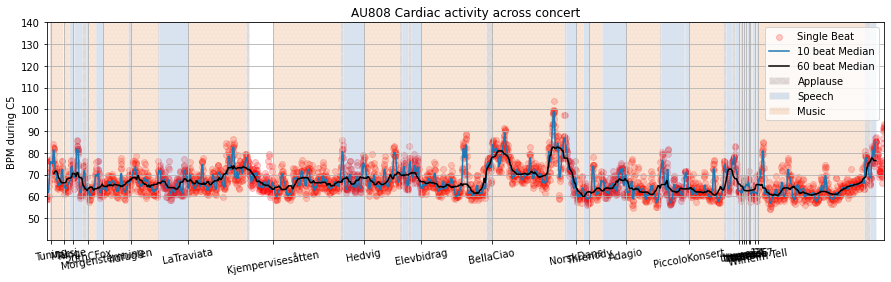

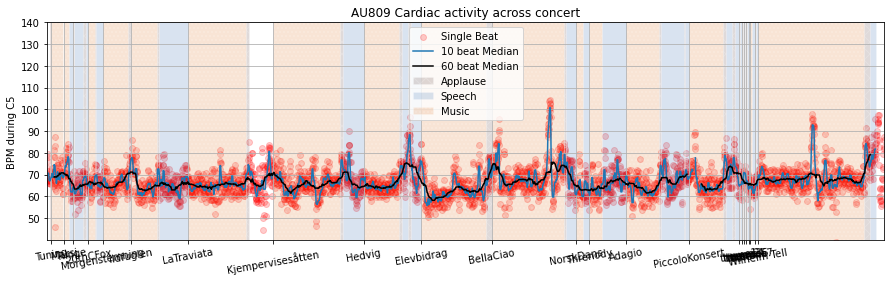

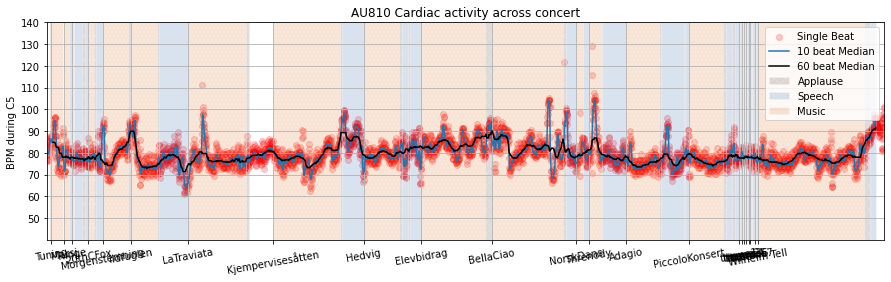

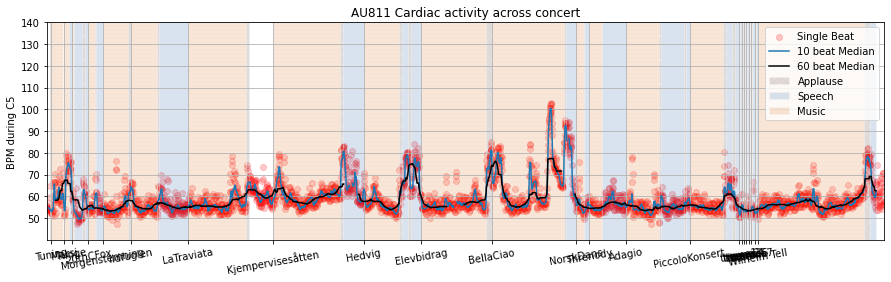

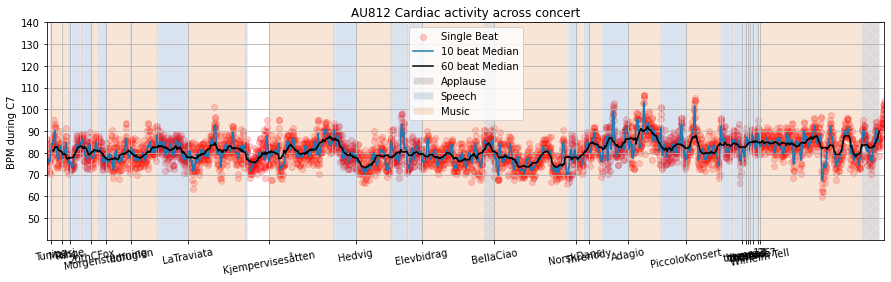

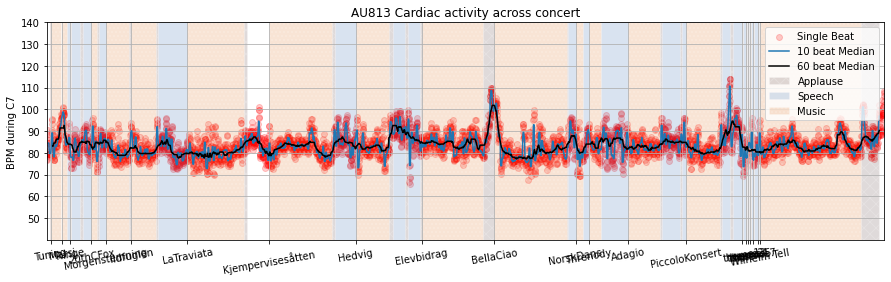

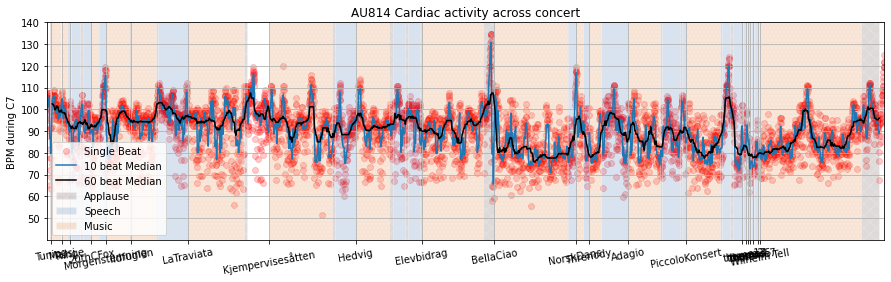

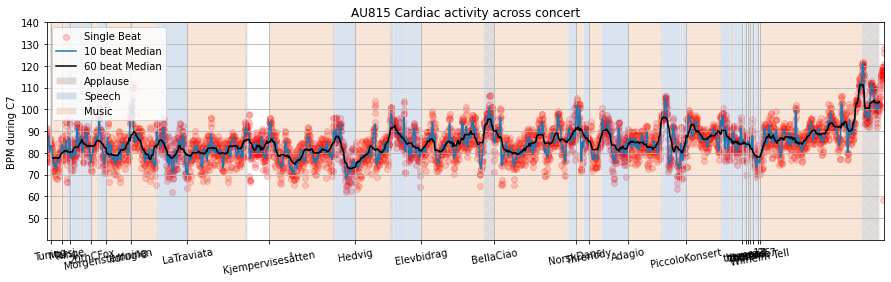

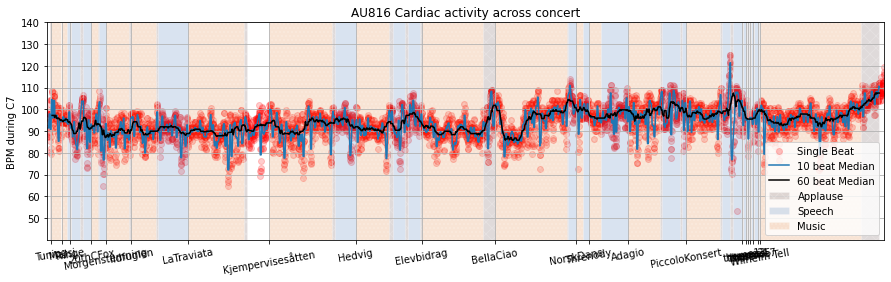

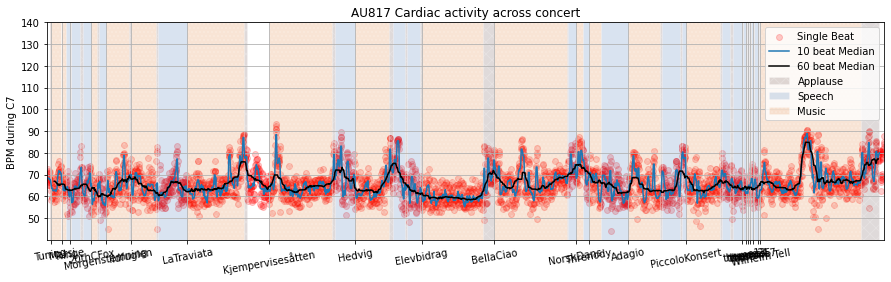

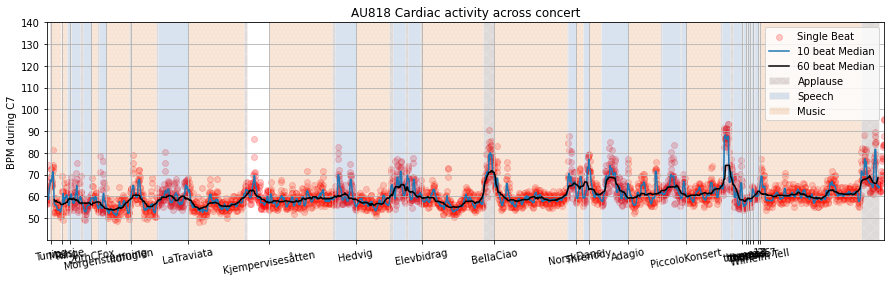

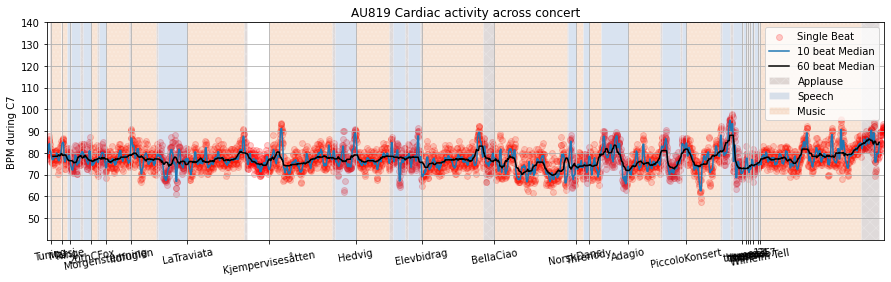

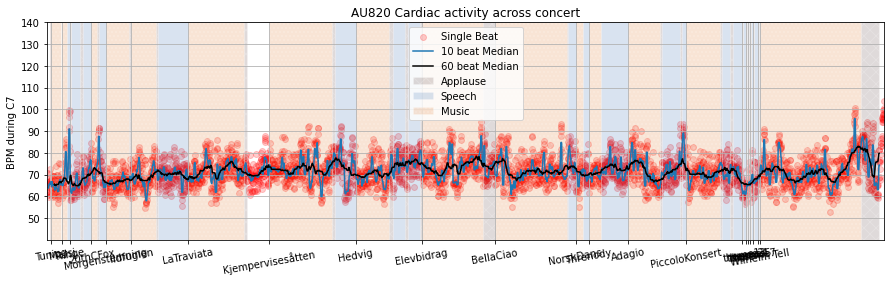

In [31]:
for concert in ['C5','C7']:
    sig_files = sig_folders[concert].copy() 

    C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
    C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
    M_times = C_times.loc[C_times['Event_Type']=='Music',:]
    bpm_range = [40,140]

    piece = 'Full'
    sf = 10
    s_time = -15 #C_times.loc[0,concert]
    e_time = C_times[concert].iloc[-1]
    dur = e_time - s_time
    time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

    C_times['Xticklabels'] = ''
    C_times.loc[C_times['Event_Type']=='Music','Xticklabels'] = C_times.loc[C_times['Event_Type']=='Music','Related']

    PartIDs = sig_files.keys()
    for p in PartIDs:
        if p.startswith('AU'):
            event_times = C_times[concert]
            event_types = C_times['Event_Type']
            M_times = C_times.loc[C_times['Event_Type']=='Music',:]

            V = pd.read_csv(sig_files[p])
            sig_t = V['c_sTime']
            sig_v = V['Interbeat Interval (MS)']
            df_sig = pd.DataFrame(index = time_s)

            fig, (ax1) = plt.subplots(1, 1,figsize = [15,4])
            ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

            HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'10 beat Median'] = f(time_s)
            df_sig.plot(ax = ax1)

            HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'60bMed'] = f(time_s)
            df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 beat Median')

            time_start =  event_times[0]-5
            event_types = event_types
            ax1.margins(0)
            for ev in event_palette.keys():
                ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
            ax1.legend()

            for i in range(len(event_times)-1):
                et = event_types[i]
                if et in event_palette.keys():
                    ei= event_times.iloc[i]
                    ej = event_times.iloc[i+1]
                    ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
            ax1.set_ylim(bpm_range)
            ax1.set_yticks([50,60,70,80,90,100,110,120,130,140])
            ax1.set_ylabel(p)

            M_times = C_times.loc[C_times['Event_Type']=='Music',:]

            ax1.set_xticks(M_times[concert])
            ax1.set_xticklabels(M_times['Event'],rotation = 10)
            ax1.grid()
            ax1.set_ylabel('BPM during ' + concert)
            ax1.set_title(' '.join([p,'Cardiac activity across concert']))
            plt.savefig('_'.join(['./plots/BPM/Cardiac',p,concert,'BPM.jpg']),bbox_inches = 'tight',dpi = 200)
            plt.show()

In [ ]:
concert = 'C5'
sig_files = sig_folders[concert].copy()   

C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

piece = 'Full'
sf = 10
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

C_times['Xticklabels'] = ''
C_times.loc[C_times['Event_Type']=='Music','Xticklabels'] = C_times.loc[C_times['Event_Type']=='Music','Related']
# C_times

In [65]:
len(PartIDs)

30

In [ ]:
datafile_type = 'EQCIBI'
piece = 'Full'
sigName = 'CIBI'
bpm_range = [40,170]
for partID in PartIDs:
    print(partID)

    fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,15])

    for j in range(len(concerts)):
        concert = concerts[j]

        C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
        C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
        M_times = C_times.loc[C_times['Event_Type']=='Music',:]
        event_times = C_times[concert]
        event_types = C_times['Event_Type']

        s_time = -15 #C_times.loc[0,concert]
        e_time = C_times[concert].iloc[-1]
        dur = e_time - s_time
        time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

        data_loc = concert_loc[concert] + piece + '/'
        sig_files = sig_folders[concert].copy() 
        if partID in sig_files.keys():
            V = pd.read_csv(sig_files[partID])

            # cut extreme outliers
            V = V.loc[V['Interbeat Interval (MS)']>330,:]
            sig_t = V['c_sTime']
            sig_v = V['Interbeat Interval (MS)']

            df_sig = pd.DataFrame(index = time_s)
            ax1 = ax[j]
            ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

            HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'10 bt Median'] = f(time_s)
            df_sig['10 bt Median'].plot(ax = ax1,label = '10 bt Median')

            HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'60bMed'] = f(time_s)
            df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')


            time_start =  event_times[0]-5
            event_types = event_types
            ax1.margins(0)
            for ev in event_palette.keys():
                ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
            if j == 0:
                #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
                ax1.legend(ncol=3)

            for i in range(len(event_times)-1):
                et = event_types[i]
                if et in event_palette.keys():
                    ei= event_times.iloc[i]
                    ej = event_times.iloc[i+1]
                    ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)

            ax1.set_ylim(bpm_range)
            ax1.set_yticks([40,60,80,100,120,140,160])
            ax1.set_xticks(M_times[concert])
            ax1.set_xticklabels(M_times['Event'],rotation = 7)
            ax1.grid()
            ax1.set_ylabel('BPM during ' + concert)

    ax[0].set_title(' '.join([partID,'Cardiac activity across concerts']))
    plt.savefig('_'.join(['./plots/BPM/Cardiac',partID,piece,'BPM.jpg']),bbox_inches = 'tight',dpi = 200)
    plt.close()


BR604
BR605
BR606
BR608
BR609
LS401
LS404
LS405
LS407
LS409
LS410
PC702
PC709
PC710
VA304
VA305
VA309
VN101
VN104
VN105
VN109
VN110
VN111
VN201
VN206
VN211
VN212
WW504
WW506
